In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import pulp

import sys
sys.path.insert(0, '../..')
import leximin_assignment
import assignment

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

import time
from tqdm import tqdm

import warnings

In [2]:
def get_ratios(cost_matrix, n):
    min_matrix = np.repeat(
        cost_matrix.min(axis=1), n
    ).reshape(cost_matrix.shape)
    increase_matrix = cost_matrix - min_matrix
    capacities = np.ones((n,))

    # Efficient assignment
    eff_assign_helper = assignment.AssignmentHelperV2(
        cost_matrix, capacities
    )

    assignments = eff_assign_helper.ip_solve()

    cost1 = eff_assign_helper.get_cost(assignments, cost_matrix=cost_matrix)

    # Bottleneck assignment
    with warnings.catch_warnings():  # temporarily suspense warnings
        warnings.simplefilter('ignore')
        leximin_assigner = leximin_assignment.LeximinAssignmentHelperV3(
            increase_matrix, capacities
        )

        leximin_assignments = leximin_assigner.solve(verbose=False)

    cost2 = leximin_assigner.get_cost(leximin_assignments, cost_matrix=cost_matrix)
    
    return cost2 / cost1

In [3]:
N = 4

cost_matrix = np.random.random_sample((N, N))
min_matrix = np.repeat(
    cost_matrix.min(axis=1), N
).reshape(cost_matrix.shape)
increase_matrix = cost_matrix - min_matrix
capacities = np.ones((N,))

cost_matrix

array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318],
       [0.4236548 , 0.64589411, 0.43758721, 0.891773  ],
       [0.96366276, 0.38344152, 0.79172504, 0.52889492],
       [0.56804456, 0.92559664, 0.07103606, 0.0871293 ]])

In [4]:
increase_matrix

array([[0.00393032, 0.17030618, 0.05788019, 0.        ],
       [0.        , 0.22223931, 0.01393241, 0.4681182 ],
       [0.58022124, 0.        , 0.40828352, 0.1454534 ],
       [0.4970085 , 0.85456058, 0.        , 0.01609324]])

In [8]:
eff_assign_helper = assignment.AssignmentHelperV2(
    cost_matrix, capacities
)

assignments = eff_assign_helper.ip_solve()
print('Assignment:')
print(assignments)
print()

cost = eff_assign_helper.get_cost(assignments)
print('Cost:')
print(cost)
print()

cost_increases = eff_assign_helper.get_cost_increases(assignments)
print('Bottleneck:')
print(cost_increases.max())

Assignment:
[1 0 2 3]

Cost:
1.3623922361767349

Bottleneck:
0.22404374597700905


# Verify bounds

In [15]:
N = 10

epsilon = 1e-3

cost_matrix = []
for i in range(1, N + 1):
    temp_row = []
    for j in range(1, N + 1):
        if j < i:
            temp_row.append(0)
        elif j == i:
            temp_row.append(1 - epsilon)
        else:
            temp_row.append(1)
    
    cost_matrix.append(temp_row)

cost_matrix[0][0] = 0
cost_matrix = (np.array(cost_matrix) * 1000).astype(int)
cost_matrix

array([[   0, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
       [   0,  999, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
       [   0,    0,  999, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
       [   0,    0,    0,  999, 1000, 1000, 1000, 1000, 1000, 1000],
       [   0,    0,    0,    0,  999, 1000, 1000, 1000, 1000, 1000],
       [   0,    0,    0,    0,    0,  999, 1000, 1000, 1000, 1000],
       [   0,    0,    0,    0,    0,    0,  999, 1000, 1000, 1000],
       [   0,    0,    0,    0,    0,    0,    0,  999, 1000, 1000],
       [   0,    0,    0,    0,    0,    0,    0,    0,  999, 1000],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  999]])

In [16]:
get_ratios(cost_matrix, N)

[0 1 2 3 4 5 6 7 8 9]


8.991

# Experiments

In [3]:
def generate_plot(n, n_experiments):
    pof_cost = []
    ordered_pof_cost = []
    
    for _ in tqdm(range(n_experiments)):
        cost_matrix = np.random.randint(0, 1000, size=(n, n)).astype(int)
        
        cost_ratio = get_ratios(cost_matrix, n)
        pof_cost.append(cost_ratio)
        
        cost_matrix.sort(axis=1)
        cost_ratio = get_ratios(cost_matrix, n)
        ordered_pof_cost.append(cost_ratio)
        
    f, ax = plt.subplots(2, 1, figsize=(20, 20), sharex=True, sharey=True)
    ax[0].hist(pof_cost, bins=20)
    ax[0].set_title('PoF (Leximin cost / efficient cost)')
    
    ax[1].hist(ordered_pof_cost, bins=20)
    ax[1].set_title('PoF with ordered cost matrices')
        
    return pof_cost, ordered_pof_cost

100%|██████████| 500/500 [2:59:18<00:00, 21.52s/it]  


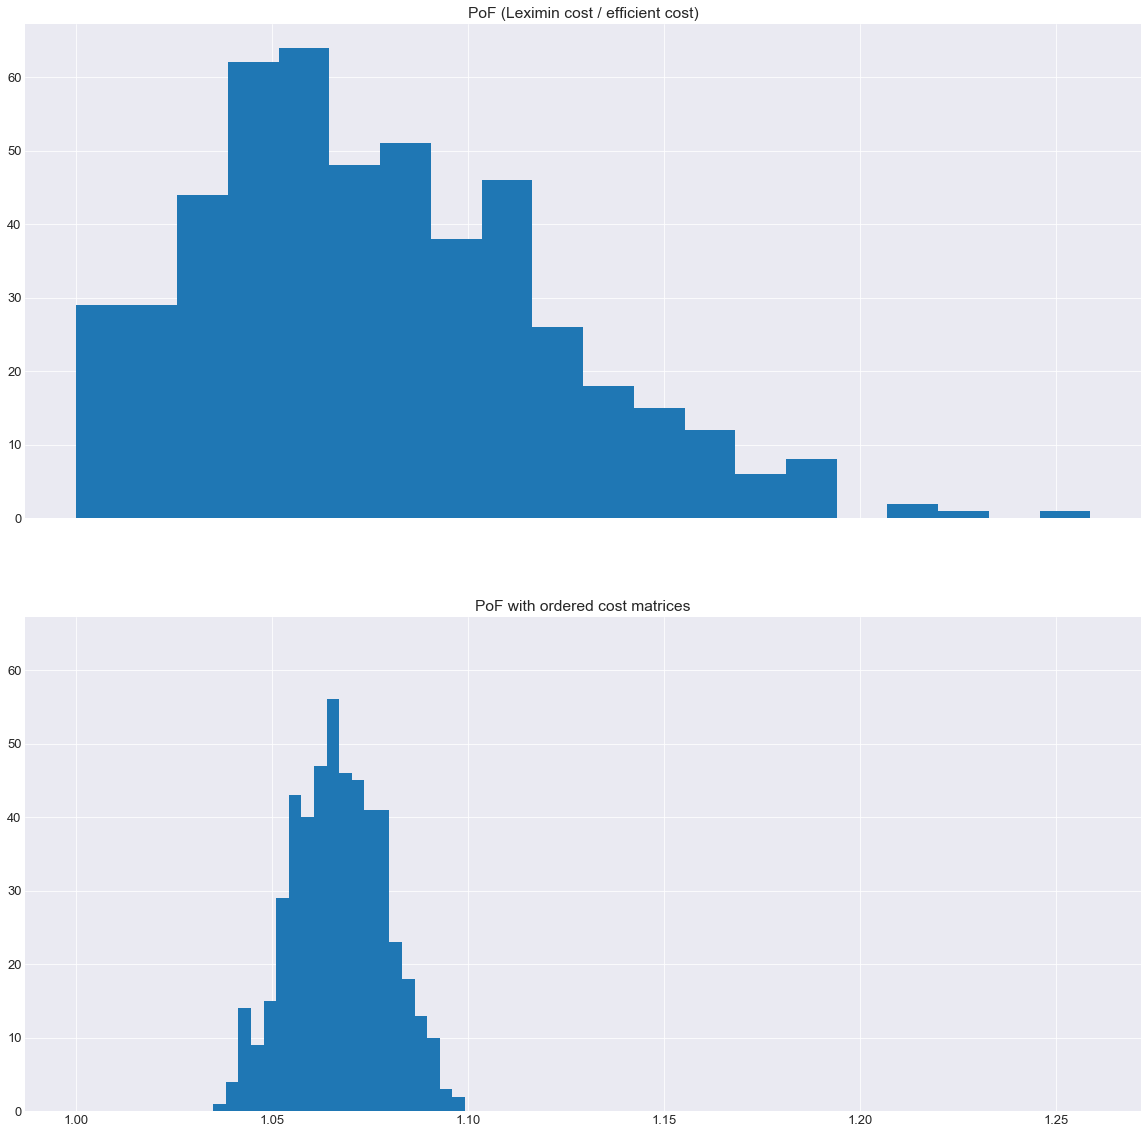

In [4]:
pofs, ordered_pofs = generate_plot(50, 500)

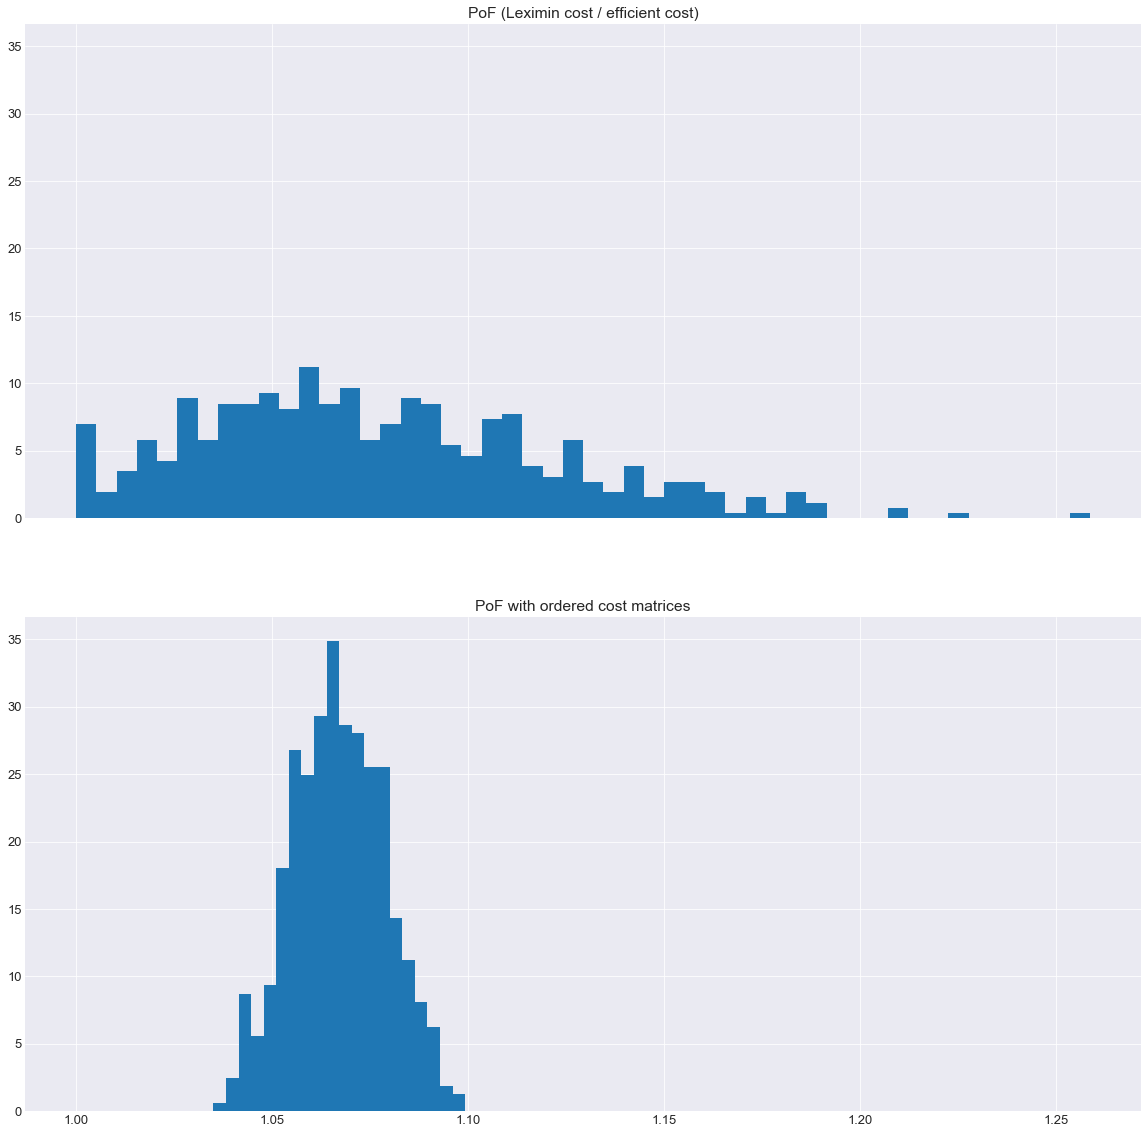

In [29]:
f, ax = plt.subplots(2, 1, figsize=(20, 20), sharex=True, sharey=True)
ax[0].hist(pofs, density=True, bins=50)
ax[0].set_title('PoF (Leximin cost / efficient cost)')

ax[1].hist(ordered_pofs, density=True, bins=20)
ax[1].set_title('PoF with ordered cost matrices')

plt.show()

In [10]:
pofs = np.array(pofs)
ordered_pofs = np.array(ordered_pofs)

In [12]:
from sklearn.neighbors import KernelDensity

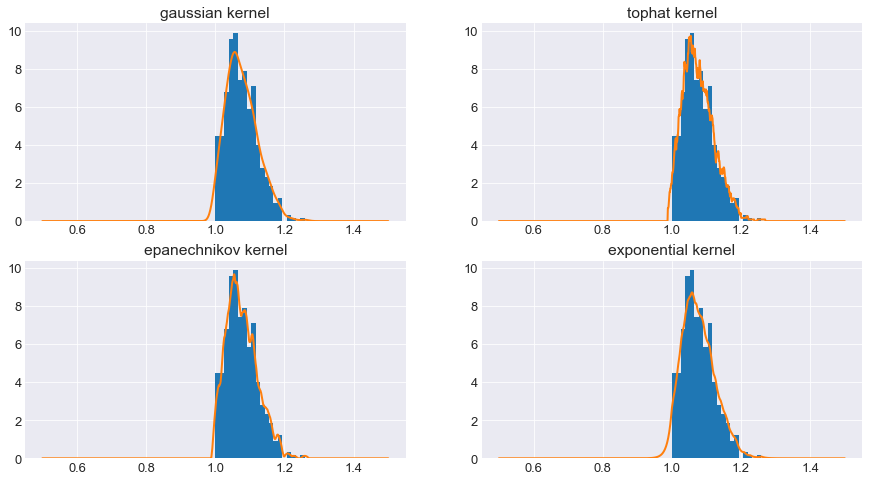

In [30]:
kernels = [
    'gaussian', 'tophat', 'epanechnikov',
    'exponential'#, 'linear', 'cosine'
]

fig, ax = plt.subplots(len(kernels) // 2, 2, figsize=(15, 2 * len(kernels)))
x_plot = np.linspace(0.5, 1.5, 1000)
bandwidth = 0.9 \
            * min(pofs.std(), np.subtract(*np.percentile(pofs, [75, 25])) / 1.34) \
            * pofs.size ** (-1 / 5)

for i, kernel in enumerate(kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(pofs[:, np.newaxis])
    log_dens = kde.score_samples(x_plot[:, np.newaxis])
    
    ax[i // 2][i % 2].hist(pofs, density=True, bins=20)
    ax[i // 2][i % 2].plot(x_plot, np.exp(log_dens), linewidth=2)
    ax[i // 2][i % 2].set_title(f'{kernel} kernel')
    
plt.show()

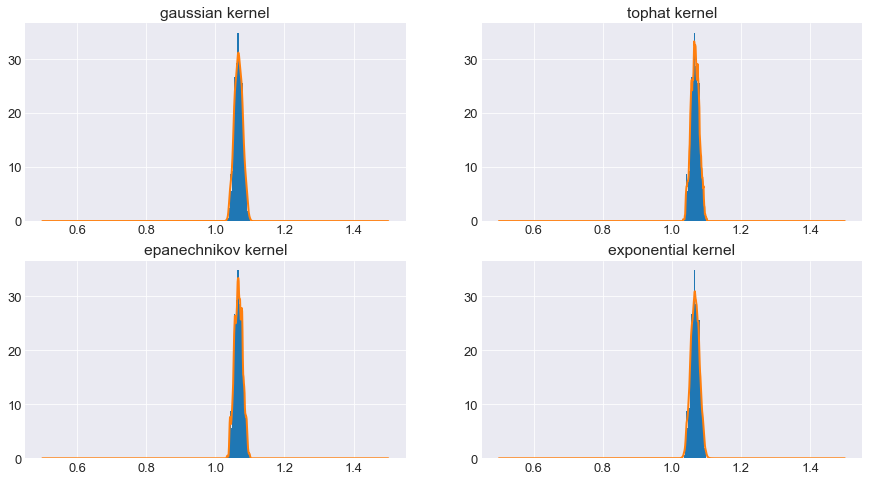

In [31]:
kernels = [
    'gaussian', 'tophat', 'epanechnikov',
    'exponential'#, 'linear', 'cosine'
]

fig, ax = plt.subplots(len(kernels) // 2, 2, figsize=(15, 2 * len(kernels)))
x_plot = np.linspace(0.5, 1.5, 1000)
bandwidth = 0.9 \
            * min(ordered_pofs.std(), np.subtract(*np.percentile(ordered_pofs, [75, 25])) / 1.34) \
            * ordered_pofs.size ** (-1 / 5)

for i, kernel in enumerate(kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(ordered_pofs[:, np.newaxis])
    log_dens = kde.score_samples(x_plot[:, np.newaxis])
    
    ax[i // 2][i % 2].hist(ordered_pofs, density=True, bins=20)
    ax[i // 2][i % 2].plot(x_plot, np.exp(log_dens), linewidth=2)
    ax[i // 2][i % 2].set_title(f'{kernel} kernel')
    
plt.show()

In [32]:
pofs.mean()

1.0766320687506004

In [33]:
ordered_pofs.mean()

1.0670006489166866